# Stock Market Prediction using Numerical and Textual Analysis
### (Level - Advanced)

#### **Objective:** Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines

#### Step 1 : Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import yfinance as yf
from textblob import TextBlob
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import nltk
nltk.download('vader_lexicon')
import warnings  
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Step 2: Importing Data

There are two datasets used in this notebook. 
1. News Dataset which have the headlines text on which we have to do sentiment analysis
2. BSE SENSEX stock dataset from yahoo finance

In [ ]:
#looking at news dataset
news = pd.read_csv("../input/newscsv/news.csv", index_col=0)
news.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


Let's know about any null values and shape of the news dataset

In [ ]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3424067 entries, 0 to 3424066
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 104.5+ MB


News Dataset have following characters:
1. 3424067 rows and 3 columns
2. No null values
3. There are multiple news headlines in single day which makes sense to have ( So we have to merge all the headlines in one single cell for a particular date)

In [ ]:
new_data = news.groupby('publish_date')['headline_text'].apply(' '.join)

In [ ]:
df1 = new_data.to_frame()
df1.reset_index(inplace= True)
df1.head()

,publish_date,headline_text
0,20010102,Status quo will not be disturbed at Ayodhya; s...
1,20010103,Powerless north India gropes in the dark Think...
2,20010104,The string that pulled Stephen Hawking to Indi...
3,20010105,Light combat craft takes India into club class...
4,20010106,Light combat craft takes India into club class...


After merging news headline of a particular date into one cell, let's look at our first news headlines for 2001/01/02

In [ ]:
print(df1.headline_text.iloc[0],"\n\n\n")
print(df1.info())

Status quo will not be disturbed at Ayodhya; says Vajpayee Fissures in Hurriyat over Pak visit America's unwanted heading for India? For bigwigs; it is destination Goa Extra buses to clear tourist traffic Dilute the power of transfers; says Riberio Focus shifts to teaching of Hindi IT will become compulsory in schools Move to stop freedom fighters' pension flayed Gilani claims he applied for passport 2 years ago Parivar dismisses PM's warning India; Pak exchange lists of N-plants Will Qureshi's return really help the govt? PM's tacit message: Put Ram tample on hold Text of the Prime Minister's article NCW to focus on violence against women BBC's reality TV will focus on AIIMS Jaitley firm on legal reforms Hoshangabad farmers have enough water BJP jumps into rail track conversion issue America's unwanted heading for India? State may take AP to court over Krishna This official has sued the briber Park turns temple compound as residents watch Moves afoot to evict squatters in Urban dist M



Looks like we don't have to clean the headline any further. 

Furthermore, this data is now have 7262 rows and 2 columns

**Now, let's download the historical stock data for BSE**

In [ ]:
#importing stock data
bse_sensex = yf.Ticker("^BSESN")

# get historical market data
hist = bse_sensex.history(start="2001-01-01",  end= "2020-12-31")
hist.reset_index(inplace= True)
hist.head(3)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,0,0,0
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,0,0,0
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,0,0,0


In [ ]:
hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4921 entries, 0 to 4920
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          4921 non-null   datetime64[ns]
 1   Open          4921 non-null   float64       
 2   High          4921 non-null   float64       
 3   Low           4921 non-null   float64       
 4   Close         4921 non-null   float64       
 5   Volume        4921 non-null   int64         
 6   Dividends     4921 non-null   int64         
 7   Stock Splits  4921 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 307.7 KB


**Stock dataset have 4921 rows since the stock market are closed in weekends**

Now, we have to merge the this two dataset on date column.

#### Step 3: Merging Datasets

In [ ]:
#removing hyphen from stock data to make it look like df1
import datetime
newdate = []
for i in hist.Date:
  newdate.append(int(i.strftime("%Y%m%d")))
hist["publish_date"] = newdate

After making sure that date column looks similar in both the dataset,
we need to create a new **Target** column, in this case it will be **Label**

Label column will be created on the basis of closed stock price of the day, If a stocks closed price of particular day is greater then its previous day closed price then Label will be 1(Price Increased) else it will be 0(Price Decreased).

In [ ]:
label = []
label.append(1)
for i in range(1,len(hist.index)):
  if hist.Close.iloc[i-1] < hist.Close.iloc[i]:
    label.append(1)
  else:
    label.append(0)
hist["Label"] = label

In [ ]:
hist.head(4)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,publish_date,Label
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,0,0,0,20010102,1
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,0,0,0,20010103,1
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,0,0,0,20010104,1
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,0,0,0,20010105,1


In [ ]:
merge = df1.merge(hist, how = 'inner', on = 'publish_date')

In [ ]:
merge.head(5)

,publish_date,headline_text,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Label
0,20010102,Status quo will not be disturbed at Ayodhya; s...,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,0,0,0,1
1,20010103,Powerless north India gropes in the dark Think...,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,0,0,0,1
2,20010104,The string that pulled Stephen Hawking to Indi...,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,0,0,0,1
3,20010105,Light combat craft takes India into club class...,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,0,0,0,1
4,20010108,Sangh Parivar; Babri panel up the ante Frontru...,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,0,0,0,0


In [ ]:
merge.shape

(4892, 11)

The new merged Data Set have 4892 rows and 11 columns. Moving forward to do a sentiment analysis on our data.

#### Step 4: Sentiment Analysis

In [ ]:
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return TextBlob(text).sentiment.polarity

In [ ]:
merge['Subjectivity'] = merge['headline_text'].apply(getSubjectivity)
merge['Polarity'] = merge['headline_text'].apply(getPolarity)

The above code will add two following columns to our merge dataset:

1. Subjectivity(range from 0 to 1) : 0 being most fictious and 1 being most real/authentic.
2. Polarity(range from 0 to 1) : 0 being most negative and 1 being most positive sentiment.

In [ ]:
def getSIA(text):
  sia = SentimentIntensityAnalyzer()
  sentiment = sia.polarity_scores(text)
  return sentiment

In [ ]:
compound = []
neg = []
pos = []
neu = []
for i in range(0,len(merge.index)):
  pol_score = getSIA(merge['headline_text'].iloc[i])
  compound.append(pol_score['compound'])
  neg.append(pol_score['neg'])
  pos.append(pol_score['pos'])
  neu.append(pol_score['neu'])

The above code will add 4 columns:

1. compound (range from -1 to 1 ) : -1 being most negative and 1 being most positive sentiment
2. neg (range from 0 to 1) : 0 being least negative and 1 being most negative sentiment
3. pos (range from 0 to 1) : 0 being least positive and 1 being most positive sentiment
4. neu (range from 0 to 1) : 0 being least neutral and 1 being most neutral sentiment

In [ ]:
merge['compound'] = compound
merge['neg'] = neg
merge['pos'] = pos
merge['neu'] = neu

**Let's have a look at our new merge dataset**

In [ ]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4892 entries, 0 to 4891
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     4892 non-null   int64  
 1   publish_date   4892 non-null   int64  
 2   headline_text  4892 non-null   object 
 3   Date           4892 non-null   object 
 4   Open           4892 non-null   float64
 5   High           4892 non-null   float64
 6   Low            4892 non-null   float64
 7   Close          4892 non-null   float64
 8   Volume         4892 non-null   int64  
 9   Dividends      4892 non-null   int64  
 10  Stock Splits   4892 non-null   int64  
 11  Label          4892 non-null   int64  
 12  Subjectivity   4892 non-null   float64
 13  Polarity       4892 non-null   float64
 14  compound       4892 non-null   float64
 15  neg            4892 non-null   float64
 16  pos            4892 non-null   float64
 17  neu            4892 non-null   float64
dtypes: float

In [ ]:
merge.tail(4)

,Unnamed: 0,publish_date,headline_text,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Label,Subjectivity,Polarity,compound,neg,pos,neu
4888,4917,20201224,How to set the mood for sex during cold winter...,2020-12-24,46743.488281,47053.398438,46539.019531,46973.539062,13700,0,0,1,0.390942,0.048166,-0.9985,0.092,0.068,0.841
4889,4918,20201228,Horoscope Today; 28 December 2020: Check astro...,2020-12-28,47153.589844,47406.718750,47148.238281,47353.750000,9600,0,0,1,0.412945,0.070517,-0.9998,0.137,0.092,0.771
4890,4919,20201229,Man recovers charred remains of 'thief' from h...,2020-12-29,47466.621094,47714.550781,47361.898438,47613.078125,12800,0,0,1,0.424021,0.061210,-0.9999,0.148,0.094,0.758
4891,4920,20201230,Numerology Readings 30 December 2020: Predicti...,2020-12-30,47789.031250,47807.851562,47358.359375,47746.218750,15600,0,0,1,0.441660,0.043496,-0.9999,0.141,0.079,0.780


There are many unwanted columns that we don't need

In [ ]:
keep = ['Open','High','Low','Subjectivity','Polarity','Volume','compound','neg','pos','neu','Label']

Let's look our final dataset that we will use to build our Model.

In [ ]:
df = merge[keep]
df.head(3)

,Open,High,Low,Subjectivity,Polarity,Volume,compound,neg,pos,neu,Label
0,3953.219971,4028.570068,3929.370117,0.282333,0.151333,0,-0.9811,0.122,0.071,0.807,1
1,3977.580078,4067.659912,3977.580078,0.407692,0.088462,0,-0.2640,0.122,0.111,0.766,1
2,4180.970215,4180.970215,4109.549805,0.446847,0.087961,0,0.8738,0.100,0.103,0.797,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4892 entries, 0 to 4891
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          4892 non-null   float64
 1   High          4892 non-null   float64
 2   Low           4892 non-null   float64
 3   Subjectivity  4892 non-null   float64
 4   Polarity      4892 non-null   float64
 5   Volume        4892 non-null   int64  
 6   compound      4892 non-null   float64
 7   neg           4892 non-null   float64
 8   pos           4892 non-null   float64
 9   neu           4892 non-null   float64
 10  Label         4892 non-null   int64  
dtypes: float64(9), int64(2)
memory usage: 420.5 KB


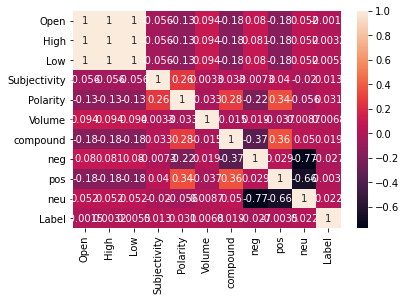

In [ ]:
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

From above correaltion plot we can see that there is highly positive correlation among open,high and low prices, whereas the neutral column have negative correlation with positive and negative sentiment columns.

#### Step 5: Model Creation & Validation

In [ ]:
X = df
X = np.array(X.drop(['Label'],1))
y = np.array(df['Label'])

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
LDA_model = LinearDiscriminantAnalysis()
LDA_model.fit(X_train,y_train)
LDA_prediction = LDA_model.predict(X_test)
print(classification_report(y_test, LDA_prediction))

              precision    recall  f1-score   support

           0       0.84      0.68      0.76       457
           1       0.76      0.89      0.82       522

    accuracy                           0.79       979
   macro avg       0.80      0.79      0.79       979
weighted avg       0.80      0.79      0.79       979



In [ ]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression().fit(X_train,y_train)
log_prediction = log_model.predict(X_test)
print(classification_report(y_test, log_prediction))

              precision    recall  f1-score   support

           0       0.81      0.78      0.80       457
           1       0.82      0.84      0.83       522

    accuracy                           0.82       979
   macro avg       0.81      0.81      0.81       979
weighted avg       0.82      0.82      0.81       979



In [ ]:
from sklearn.ensemble import RandomForestClassifier
re_model = RandomForestClassifier().fit(X_train,y_train)
re_prediction = re_model.predict(X_test)
print(classification_report(y_test, re_prediction))

              precision    recall  f1-score   support

           0       0.51      0.41      0.45       457
           1       0.56      0.65      0.60       522

    accuracy                           0.54       979
   macro avg       0.53      0.53      0.53       979
weighted avg       0.53      0.54      0.53       979



In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc_model = DecisionTreeClassifier().fit(X_train,y_train)
dtc_prediction = dtc_model.predict(X_test)
print(classification_report(y_test, dtc_prediction))

              precision    recall  f1-score   support

           0       0.49      0.47      0.48       457
           1       0.55      0.57      0.56       522

    accuracy                           0.52       979
   macro avg       0.52      0.52      0.52       979
weighted avg       0.52      0.52      0.52       979



#### Step 6: Conclusion

After using various models, It looks like that Logistic Regression will be best model to predict whether the BSE SENSEX stock price will be high or low with an 82% of accuracy.